In [65]:
import os
import sys
import yaml

import matplotlib.pyplot as plt
import networkx as nx

import torch
import torch.nn as nn
import torchvision.transforms as T

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

from models.resnet_simclr import ResNetSimCLR
from data_aug.to_rgb import ToRGB

In [ ]:
transforms = T.Compose([
    ToRGB(),
    T.Resize((32, 32)),
    T.ToTensor(),
])
batch_size = 16
dataset = MNIST(root='./data', train=False, download=True, transform=transforms)
loader = DataLoader(dataset, shuffle=True, batch_size=batch_size)

checkpoint_root = './runs/Jul23_15-46-16_matrix/checkpoints/'

with open(os.path.join(checkpoint_root, 'config.yaml'), 'r') as f:
    config = yaml.load(
        f, Loader=yaml.Loader)

weights = torch.load(os.path.join(checkpoint_root, 'model.pth'))
model = ResNetSimCLR(**config['model'])
model.load_state_dict(weights)
model

In [30]:
L = len(dataset)
encodings = torch.zeros(L, 512)

model.eval()
with torch.no_grad():
    for i, (X, y) in enumerate(loader):
        sys.stdout.write(f'{(i+1)*batch_size}              \r')
        sys.stdout.flush()

        h, _ = model(X)
        encodings[batch_size*i:batch_size*(i+1)] = h

encodings[:5]

tensor([[2.8343, 3.5582, 0.0000,  ..., 3.3854, 0.0000, 1.7739],
        [1.3528, 0.0000, 0.0000,  ..., 3.0598, 3.2682, 0.0000],
        [0.0000, 0.0000, 0.6198,  ..., 0.5883, 0.0000, 0.0000],
        [0.5239, 0.0000, 0.0000,  ..., 3.4509, 1.8365, 1.7986],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.3380, 0.6070]])

In [50]:
cosine_similarity = nn.CosineSimilarity(dim=-1)
similarities = torch.zeros(L, L)

for i in range(L):
    sys.stdout.write(f'{i+1}/{L}            \r')
    sys.stdout.flush()
    
    similarity = cosine_similarity(encodings[i], encodings)
    similarities[i] = similarity


In [52]:
similarities[:8, :8]

tensor([[1.0000, 0.2242, 0.2179, 0.4586, 0.0984, 0.1679, 0.1926, 0.6055],
        [0.2242, 1.0000, 0.5036, 0.7256, 0.4222, 0.6546, 0.1872, 0.3056],
        [0.2179, 0.5036, 1.0000, 0.4789, 0.4047, 0.7571, 0.2310, 0.4324],
        [0.4586, 0.7256, 0.4789, 1.0000, 0.3040, 0.6363, 0.0894, 0.7043],
        [0.0984, 0.4222, 0.4047, 0.3040, 1.0000, 0.5932, 0.2888, 0.2876],
        [0.1679, 0.6546, 0.7571, 0.6363, 0.5932, 1.0000, 0.1690, 0.4919],
        [0.1926, 0.1872, 0.2310, 0.0894, 0.2888, 0.1690, 1.0000, 0.1072],
        [0.6055, 0.3056, 0.4324, 0.7043, 0.2876, 0.4919, 0.1072, 1.0000]])

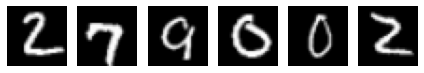

In [59]:
k = 6
scores, idxs = torch.topk(similarities[0], k=k)
fig, ax = plt.subplots(1, k)
to_pil = T.ToPILImage()

for i in range(k):
    X, _ = dataset[idxs[i]]
    ax[i].imshow(to_pil(X))
    ax[i].axis('off')
    
plt.tight_layout()

In [62]:
def nearest_neigbors_sparsify(similarities, k):
    top_similarities = similarities.clone()

    for i in range(L):
        _, idxs = torch.topk(similarities[i], k=k)
        mask = torch.zeros(L)
        mask[idxs] = 1
        top_similarities[i] *= mask

    return top_similarities
    
top_similarities = nearest_neighbors_sparsify(similarities, k)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [79]:
G = nx.from_numpy_matrix(top_similarities.numpy()[:2000, :2000], parallel_edges=True)

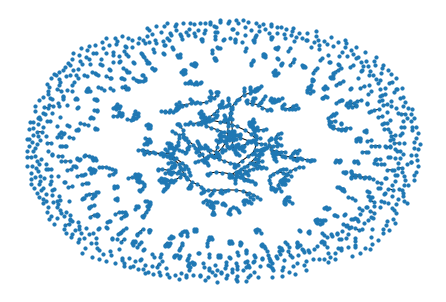

In [80]:
nx.draw(G, node_size=10)